# Using Dask to Compute AIA Timelags in Parallel
## Will Barnes<sup>1</sup> and Stuart Mumford<sup>2</sup>
### <sup>1</sup> Department of Physics and Astronomy, Rice University <sup>2</sup>University of Sheffield

In this notebook, we'll show an example of how to use Dask to efficiently compute the timelag between two AIA channels from multi-wavelength AIA data. **The goal of this notebook is to show how Dask allows us to treat many individual FITS files as a single, out-of-core data cube.** By constructing a data cube from our stacks of FITS files for each EUV channel of AIA, we can scale the computation of the timelag in each pixel of the image across *many* computing cores. By structuring the data in this way, we are able to effectively leverage our computational resources against our large volume of data.

## Import Packages

First, we'll need to import a bunch of packages. Most importantly, we'll need the SunPy and Astropy libraries.

**Note: For this example, we need the bleeding-edge version of SunPy. This can be installed from GitHub. Once SunPy v1.0 is released, this will not be necessary.**

In [1]:
! conda uninstall sunpy -y
! pip install git+git://github.com/sunpy/sunpy.git

Solving environment: done

## Package Plan ##

  environment location: /srv/conda

  removed specs: 
    - sunpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.10.15         |        py36_1000         138 KB  conda-forge
    openssl-1.0.2p             |       h470a237_1         3.1 MB  conda-forge
    ca-certificates-2018.10.15 |       ha4d7672_0         135 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following packages will be REMOVED:

    sunpy:           0.9.3-py36_0      conda-forge

The following packages will be UPDATED:

    ca-certificates: 2018.03.07-0      defaults    --> 2018.10.15-ha4d7672_0 conda-forge
    certifi:         2018.10.15-py36_0 defaults    --> 2018.10.15-py36_1000  conda-forge
    openssl:         1.0.2p-h14c3975_0 defaults    --> 1.0.2p-h4

In [2]:
import os
import sys
import glob
import datetime

import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import shift
import matplotlib.pyplot as plt
import dask
import dask.array as da
import distributed
from dask_kubernetes import KubeCluster
import gcsfs
from astropy.time import Time
import astropy.io
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io.fits.hdu.base import BITPIX2DTYPE
import sunpy
from sunpy.map import Map
from sunpy.instr.aia import aiaprep
from sunpy.physics.differential_rotation import diffrot_map,solar_rotate_coordinate
from sunpy.util.metadata import MetaDict
import matplotlib.colors

%matplotlib inline

Let's check that we've got the most recent version of SunPy. This should read `1.0.0.dev<commit-number>`

In [3]:
sunpy.version.version

'1.0.0.dev10026'

We'll be using a set of AIA data that has already been uploaded to Pangeo. This data consists of 6 hours of consecutive full-disk observations in the six EUV passbands of the AIA instrument: 94, 131, 171, 193, 211, and 335 Å.

Additionally, we've also created a "prepped" and "derotated" version of this dataset in which we've scaled all channels to a common resolution and removed the effect of differential rotation on the Sun such that, over time, the same pixel corresponds (approximately) to the same patch of Sun.

In [4]:
gcs = gcsfs.GCSFileSystem()
sorted(gcs.ls('pangeo-data/SDO_AIA_Images/diffrot/'))

['pangeo-data/SDO_AIA_Images/diffrot/094/',
 'pangeo-data/SDO_AIA_Images/diffrot/131/',
 'pangeo-data/SDO_AIA_Images/diffrot/171/',
 'pangeo-data/SDO_AIA_Images/diffrot/193/',
 'pangeo-data/SDO_AIA_Images/diffrot/211/',
 'pangeo-data/SDO_AIA_Images/diffrot/335/']

In [5]:
SAVE_DIR = 'gcs://pangeo-data/SDO_AIA_Images/diffrot/'

## Spin Up Cluster

Now, let's create our Dask cluster. Because we are running on Pangeo, we can do this via the Dask Kubernetes module.

In [6]:
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=100)
cluster

In [7]:
cluster.dashboard_link

'/user/wtbarnes/proxy/8787/status'

In [8]:
client = distributed.Client(cluster)

## Data Cubes from FITS Files

As noted previously, AIA data are stored in the FITS format, where the 4K-by-4K image at each timestep and wavelength is stored in an individual file. This means to form a timeseries for a given wavelength, we need to combine 6 hours worth of data. At a 12 s cadence, this works out to 1800 files per wavelength. 

First, let's define a data structure for stacking multiple FITS files to create an AIA data cube. This cube will be "lazily" evaluated such that the data will not be immediately loaded into memory. We'll call this object `AIACube`

In [9]:
def validate_dtype_shape(head):
    naxes = head['NAXIS']
    dtype = BITPIX2DTYPE[head['BITPIX']]
    shape = [head[f'NAXIS{n}'] for n in range(naxes, 0, -1)]
    return dtype, shape


def get_header(fn, hdu=0):
    with fn as fi:
        return MetaDict(sunpy.io.fits.get_header(fi)[hdu])


class DelayedFITS:
    def __init__(self, file, shape, dtype, hdu=0, verify=False):
        self.shape = shape
        self.dtype = dtype
        self.file = file
        self.hdu = hdu
        self.verify = verify

    def __getitem__(self, item):
        with self.file as fi:
            with astropy.io.fits.open(fi, memmap=True) as hdul:
                if self.verify:
                    hdul.verify('silentfix+warn')
                return hdul[self.hdu].data[item]


class AIACube(object):

    def __init__(self, maps):
        if not all([m.data.shape == maps[0].data.shape for m in maps]):
            raise ValueError('All maps must have same dimensions')
        if not all([m.data.dtype == maps[0].data.dtype for m in maps]):
            raise ValueError('All maps must have same dtype')
        self.maps = maps
        self.time = self._get_time()

    @classmethod
    def from_files(cls, fits_files, **kwargs):
        openfiles = dask.bytes.open_files(fits_files)
        headers = cls._get_headers(openfiles, **kwargs)
        dtype, shape = cls._get_dtype_and_shape(headers)
        maps = cls._get_maps(openfiles, headers, dtype, shape, **kwargs)
        return cls(maps)

    @staticmethod
    def _get_maps(openfiles, headers, dtype, shape, **kwargs):
        hdu = kwargs.get('hdu', 0)
        verify = kwargs.get('verify', False)
        arrays = [da.from_array(DelayedFITS(f, shape, dtype, hdu=hdu, verify=verify), chunks=shape)
                  for f in openfiles]
        return [Map(a, h) for a, h in zip(arrays, headers)]

    @staticmethod
    def _get_headers(openfiles, **kwargs):
        client = distributed.get_client()
        futures = client.map(get_header, openfiles, hdu=kwargs.get('hdu', 0))
        return client.gather(futures)

    @staticmethod
    def _get_dtype_and_shape(headers):
        dtypes = [validate_dtype_shape(h) for h in headers]
        if not all([d == dtypes[0] for d in dtypes]):
            raise ValueError('All maps must have same shape and dtype')
        return dtypes[0]

    def _get_time(self,):
        return u.Quantity([(Time(m.meta['t_obs']) - Time(self.maps[0].meta['t_obs'])).to(u.s) 
                            for m in self.maps])

    @property
    def shape(self,):
        return self.time.shape + self.maps[0].data.shape

    @property
    def dtype(self,):
        return self.maps[0].data.dtype

    @property
    def unstacked_data(self,):
        return [m.data for m in self.maps]

    @property
    def stacked_data(self,):
        return da.stack(self.unstacked_data)

    def rechunk(self, shape):
        return self.stacked_data.rechunk(shape)

    def average(self, **kwargs):
        #chunks = kwargs.get('chunks', (self.shape[0], self.shape[1]//10, self.shape[2]//10))
        #cube = self.rechunk(chunks)
        return sunpy.map.Map(self.stacked_data.mean(axis=0, dtype=np.float64), self.maps[0].meta.copy())

    def submap(self, *args, **kwargs):
        return AIACube([m.submap(*args, **kwargs) for m in self.maps])

Let's create a data cube for the 171 Å channel.

In [10]:
cube = AIACube.from_files(os.path.join(SAVE_DIR, '171/*.fits' ))

Note that we've only read in the metadata and not the actual data. This is the *lazy* part of structure. The data is only read in when needed. However, we can still treat it much like a "dense" data structure.

In [11]:
cube.dtype

dtype('float64')

In [12]:
cube.shape # time, space, space

(1800, 4096, 4096)

Let's take a look at the first map.

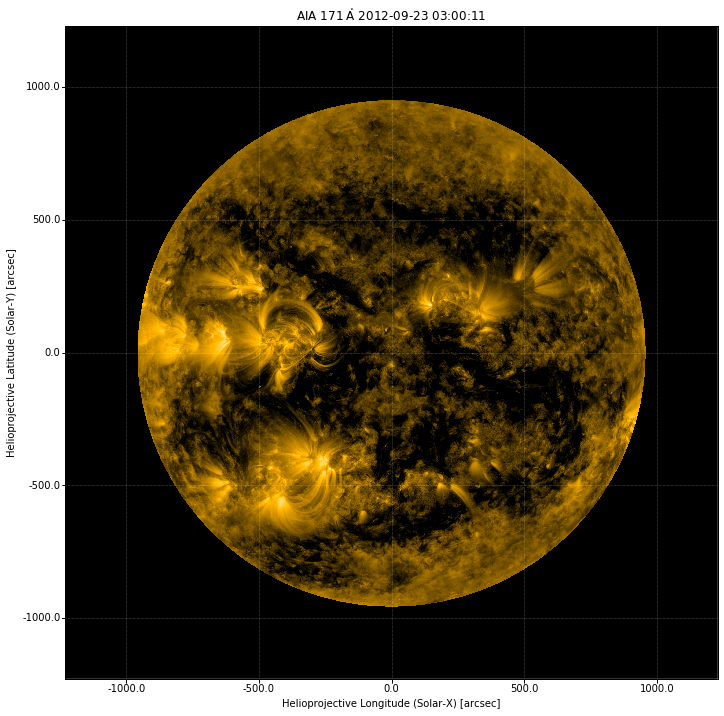

In [13]:
plt.figure(figsize=(12,12))
cube.maps[0].plot(vmin=1e2,vmax=1e4)

We'll also identify the active region (AR) we are interested in. Note that we can crop each map in the same place as we have already removed the effect of the rotation of the Sun.

In [14]:
m = cube.maps[0]
blc = SkyCoord(-600*u.arcsec,-150*u.arcsec,frame=m.coordinate_frame)
trc = SkyCoord(-200*u.arcsec,250*u.arcsec,frame=m.coordinate_frame)

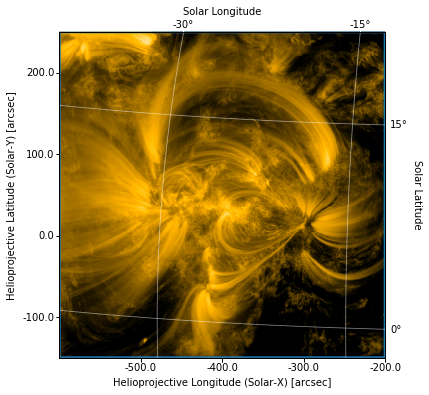

In [15]:
fig = plt.figure(figsize=(6,6))
m_sub = m.submap(blc,trc)
ax = fig.gca(projection=m_sub)
m_sub.plot(axes=ax,title=False,vmin=1e2,vmax=1e4)
m_sub.draw_rectangle(blc,(trc.Tx - blc.Tx), (trc.Ty - blc.Ty), color='C0', lw=3)
ax.grid(alpha=0)
m_sub.draw_grid(axes=ax,)

Additionally, we can take a time average over the whole cube.

In [17]:
cube_average = cube.average()

However, the average is only computed when we need it. Until then, the data is represented as a Dask array, though we do have access to all of the necessary metadata.

In [18]:
cube_average

SunPy Map
---------
Observatory:		 SDO
Instrument:		 AIA 3
Detector:		 AIA
Measurement:		 171.0 Angstrom
Wavelength:		 171.0 Angstrom
Observation Date:	 2012-09-23 03:00:11
Exposure Time:		 1.999586 s
Dimension:		 [4096. 4096.] pix
Coordinate System:	 helioprojective
Scale:			 [0.6 0.6] arcsec / pix
Reference Pixel:	 [2048.5 2048.5] pix
Reference Coord:	 [0. 0.] arcsec
dask.array<mean_agg-aggregate, shape=(4096, 4096), dtype=float64, chunksize=(4096, 4096)>

**NOTE: This takes a few minutes and can be skipped**

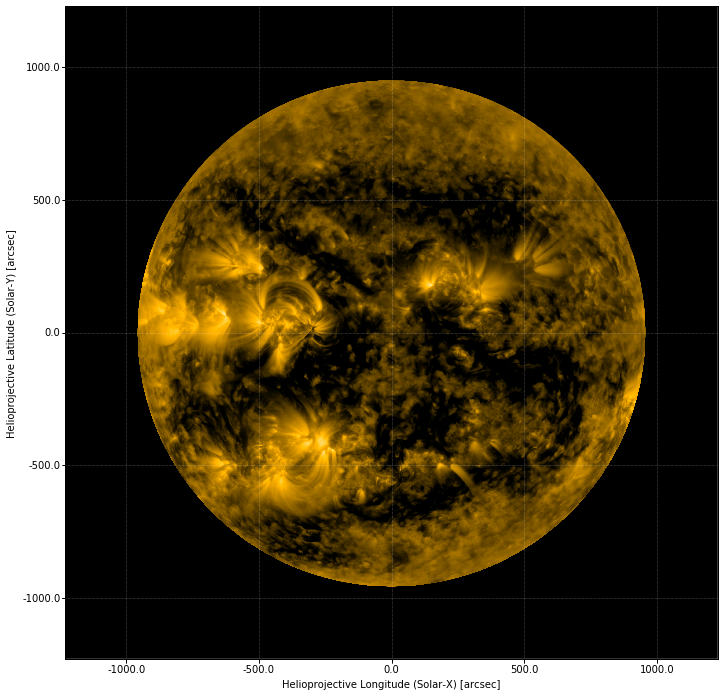

In [19]:
plt.figure(figsize=(12,12))
cube_average.plot(title=False,vmin=1e2,vmax=1e4)

Now, let's create a cube for each wavelength. 

In [20]:
channels = [94,131,171,193,211,335]

**NOTE: This may take a few minutes.**

In [21]:
cubes = [AIACube.from_files(os.path.join(SAVE_DIR, f'{c:03d}/*.fits' )) for c in channels]

We also need to normalize each channel to the exposure time. This is typically part of the "prepping" process. We can do this simply by dividing each map in each cube by the exposure time as found in the map metadata. We'll also only take every 10th map to reduce the compute time. This reduces our data from the 12 s cadence of the AIA instrument to a 2 minute time resolution. The computation is just a bit slower at the full cadence.

In [22]:
cubes = [AIACube([Map(m.data/m.meta['exptime'], m.meta) for m in c.maps[::10]]) for c in cubes]

Lastly, we'll add the cropping (or submap) step to our pipeline since we are only interested in computing the timelags for one particular active region.

**NOTE: This may take a few minutes.**

In [23]:
cubes = [c.submap(blc,trc) for c in cubes]

## Timelags

To do some science, we want to calculate the timelag in each pixel of our map. The **timelag**, or the delay which maximizes the cross-correlation between two timeseries, is a useful quantity for understanding the thermal evolution of the coronal plasma between the passbands of the AIA instrument.

In temperature space, the EUV passbands on AIA have the following structure.

![](http://iopscience.iop.org/0004-637X/753/1/35/downloadFigure/figure/apj431449f1)

These are the so-called "temperature response functions" and they show approximately what temperatures each channel or passband is sensitive too.

As a blob of coronal plasma cools from 10 MK down to below 1 MK, we expect to see the intensity peak in consecutively cooler channels. If we then compute the cross-correlate of the intensity timeseries in two different channels as a function of the temporal offset between those two timeseries, the offset which maximizes the cross-correlation is the **timelag**. The timelag can then be used as a proxy for the plasma cooling time between two passbands.

This method was first applied to AIA data by [Viall and Klimchuk (2012)](http://iopscience.iop.org/article/10.1088/0004-637X/753/1/35/meta). They computed the timelag in every pixel of AR NOAA 11082 as observed by AIA. In doing so, they revealed large-scale cooing patterns across the entire active region. An example of several cross-correlation curves in a single pixel is shown below. When computing timelags between AIA channel pairs, we order the channel pairs by decreasing temperature such that a positive timelag implies the peak in the hot channel preceeded the peak in the cooler channel. **Using this convention, a positive timelag implies cooling plasma.**

![](http://iopscience.iop.org/0004-637X/753/1/35/downloadFigure/figure/apj431449f4)

Mathematically, we can express the timelag in terms of a Fourier transform, making it very simple to compute with Dask. We can express the cross-correlation $\mathcal{C}$ between two channels $A$ and $B$ as,

$$
    \mathcal{C}_{AB}(\tau) = \mathcal{I}_A(t)\star\mathcal{I}_B(t) = \mathcal{I}_A(-t)\ast\mathcal{I}_B(t)
$$

where $\star$ and $\ast$ represent the correlation and convolution operators, respectively, $\tau$ is the lag and

$$
    \mathcal{I}_c(t)=\frac{I_c(t)-\bar{I}_c}{\sigma_{c}},
$$

is the mean-subtracted and scaled intensity of channel $c$ as a function of time. Taking the fourier transform of both sides of the first equation and using the convolution theorem,

$$
\begin{align}
    \mathcal{F}\{\mathcal{C}_{AB}(\tau)\} &= \mathcal{F}\{\mathcal{I}_A(-t)\ast\mathcal{I}_B(t)\},\\
    &= \mathcal{F}\{\mathcal{I}_A(-t)\}\mathcal{F}\{\mathcal{I}_B(t)\}.
\end{align}
$$

Taking the inverse Fourier transform, $\mathcal{F}^{-1}$, of both sides of the above expression gives,

$$
    \mathcal{C}_{AB}(\tau) = \mathcal{F}^{-1}\{\mathcal{F}\{\mathcal{I}_A(-t)\}\mathcal{F}\{\mathcal{I}_B(t)\}\}.
$$

Scaling $\mathcal{C}_{AB}$ by the length of the intensity timeseries $I(t)$ yields the same result as that of the correlation defined in section 2 of [Viall and Klimchuk (2012)](http://iopscience.iop.org/article/10.1088/0004-637X/753/1/35/meta). Furthermore, the **timelag** between channels $A$ and $B$ is defined as,
$$
    \tau_{AB} = \mathrm{argmax}_{\tau}\,\mathcal{C}_{AB}(\tau).
$$

Fortunately for us, all of these operations are already implemented in `dask.array`! Since we have already shaped our data into a data cube, we just need to build the graph appropriately.

Now, we'll create a class to hold cubes for all EUV wavelengths and can compute the timelag in each pixel of our observation and return the resulting timelag to a single `Map` object for each pair of AIA EUV channels. This class also includes a method (`cross_correlation`) for computing the cross-correlation in each pixel of our image.

In [24]:
class AIATimelags(object):
    def __init__(self, *args, **kwargs):
        if not all([a.shape[1:] == args[0].shape[1:] for a in args]):
            raise ValueError('All spatial dimensions must be the same')
        if not all([a.shape[0] == args[0].shape[0] for a in args]):
            warnings.warn('Time dimensions are not all equal length')
        self._cubes = {a.maps[0].meta['wavelnth']: a for a in args}
        self.channels = sorted(list(self._cubes.keys()), key=lambda x: x)

    def __getitem__(self, channel):
        # Index
        if type(channel) is int and channel not in self.channels:
            channel = self.channels[channel]
        # Convert from string
        if type(channel) is str:
            channel = float(channel)
        return self._cubes[channel]
    
    @property
    def needs_interpolation(self,):
        if not all([c.shape[0] == self[0].shape[0] for c in self]):
            return True
        return ~np.all([u.allclose(c.time, self[0].time) for c in self])

    @property
    def timelags(self):
        time = self._interpolate_time if self.needs_interpolation else self[0].time
        delta_t = np.diff(time.value).cumsum()
        return np.hstack([-delta_t[::-1], np.array([0]), delta_t]) * time.unit
    
    @property
    def _interpolate_time(self,):
        min_t = min([c.time.min() for c in self])
        max_t = max([c.time.max() for c in self])
        n_t = max([c.time.shape[0] for c in self])
        return np.linspace(min_t, max_t, n_t)
    
    def _interpolate(self, time, cube):
        t_interp = self._interpolate_time
        def interp_wrapper(y):
            return interp1d(time, y, axis=0, kind='linear', fill_value='extrapolate')(t_interp)
        return da.map_blocks(interp_wrapper, cube, chunks=t_interp.shape+cube.chunks[1:],
                             dtype=cube.dtype)

    def cross_correlation(self, channel_a, channel_b, **kwargs):
        # Shape must be the same in spatial direction
        chunks = kwargs.get('chunks', (self[channel_a].shape[1]//10,
                                       self[channel_a].shape[2]//10))
        cube_a = self[channel_a].rechunk(self[channel_a].shape[:1]+chunks)
        cube_b = self[channel_b].rechunk(self[channel_b].shape[:1]+chunks)
        if self.needs_interpolation:
            cube_a = self._interpolate(self[channel_a].time, cube_a)
            cube_b = self._interpolate(self[channel_b].time, cube_b)
        # Reverse the first timeseries
        cube_a = cube_a[::-1, :, :]
        # Normalize by mean and standard deviation
        std_a = cube_a.std(axis=0)
        std_a = da.where(std_a == 0, 1, std_a)
        v_a = (cube_a - cube_a.mean(axis=0)[np.newaxis, :, :]) / std_a[np.newaxis, :, :]
        std_b = cube_b.std(axis=0)
        std_b = da.where(std_b == 0, 1, std_b)
        v_b = (cube_b - cube_b.mean(axis=0)[np.newaxis, :, :]) / std_b[np.newaxis, :, :]
        # FFT of both channels
        fft_a = da.fft.rfft(v_a, axis=0, n=self.timelags.shape[0])
        fft_b = da.fft.rfft(v_b, axis=0, n=self.timelags.shape[0])
        # Inverse of product of FFTS to get cross-correlation (by convolution theorem)
        cc = da.fft.irfft(fft_a * fft_b, axis=0, n=self.timelags.shape[0])
        # Normalize by the length of the timeseries
        return cc / cube_a.shape[0]

    def make_correlation_map(self, channel_a, channel_b, **kwargs):
        cc = self.cross_correlation(channel_a, channel_b, **kwargs)
        bounds = kwargs.get('timelag_bounds', None)
        if bounds is not None:
            indices, = np.where(np.logical_and(self.timelags >= bounds[0],
                                               self.timelags <= bounds[1]))
            start = indices[0]
            stop = indices[-1] + 1
        else:
            start = 0
            stop = self.timelags.shape[0] + 1
        max_cc = cc[start:stop, :, :].max(axis=0).compute()
        meta = self[channel_a].maps[0].meta.copy()
        del meta['instrume']
        del meta['t_obs']
        del meta['wavelnth']
        meta['bunit'] = ''
        meta['comment'] = f'{channel_a}-{channel_b} cross-correlation'
        plot_settings = {'cmap': 'plasma'}
        plot_settings.update(kwargs.get('plot_settings', {}))
        correlation_map = sunpy.map.GenericMap(max_cc, meta, plot_settings=plot_settings)

        return correlation_map

    def make_timelag_map(self, channel_a, channel_b, **kwargs):
        cc = self.cross_correlation(channel_a, channel_b, **kwargs)
        bounds = kwargs.get('timelag_bounds', None)
        if bounds is not None:
            indices, = np.where(np.logical_and(self.timelags >= bounds[0],
                                               self.timelags <= bounds[1]))
            start = indices[0]
            stop = indices[-1] + 1
        else:
            start = 0
            stop = self.timelags.shape[0] + 1
        i_max_cc = cc[start:stop, :, :].argmax(axis=0).compute()
        max_timelag = self.timelags[start:stop][i_max_cc]
        meta = self[channel_a].maps[0].meta.copy()
        del meta['instrume']
        del meta['t_obs']
        del meta['wavelnth']
        meta['bunit'] = 's'
        meta['comment'] = f'{channel_a}-{channel_b} timelag'
        plot_settings = {'cmap': 'RdBu_r', 'vmin': self.timelags[start:stop].value.min(),
                         'vmax': self.timelags[start:stop].value.max()}
        plot_settings.update(kwargs.get('plot_settings', {}))
        timelag_map = sunpy.map.GenericMap(max_timelag, meta.copy(),
                                           plot_settings=plot_settings.copy())
        return timelag_map

Now, let's create our timelag object

In [25]:
timelags = AIATimelags(*cubes)

## Compute and Visualize

Finally, let's compute a timelag in every pixel of the AR! Because the computation in each pixel is independent, we can distribute the spatial dimensions across multiple cores.

Let's first compute the timelag map for the 335-171 Å channel pair.

In [26]:
#%%timeit -n 1 -r 1
tl_335_171 = timelags.make_timelag_map(335,171,timelag_bounds=(-3*u.hour,3*u.hour),)

By creating this timelag map, we are telling Dask to execute the following chain of operations:

1. Divide each map by the exposure time
2. Crop each map to the selected active region
3. Stack all of the maps together and "rechunk" the array along the time axis
4. Interpolate the two channels to a common time array
5. Scale the intensity by the mean and standard deviation in each pixel
6. Compute $\mathcal{C}_{AB}$ (see above expression) in each pixel 
7. Find the timelag $\tau$ that maximizes $\mathcal{C}_{AB}$

Dask then takes care of farming out this task graph to all available workers. The `make_timelag_map` method then takes the resulting array and builds a SunPy map from the result with the appropriate metadata inherited from our original intensity data.

We can plot our result just as we do any other SunPy map.

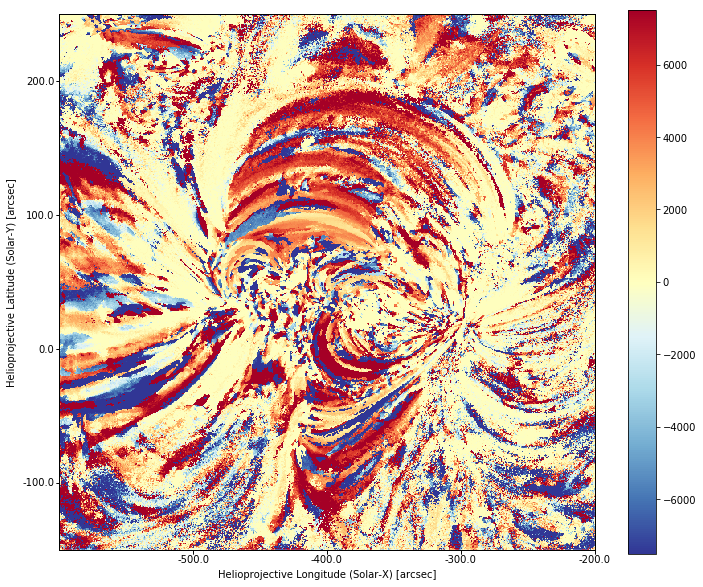

In [27]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_335_171)
im = tl_335_171.plot(axes=ax,vmin=-7.5e3,vmax=7.5e3,cmap='RdYlBu_r',title=False)
ax.grid(alpha=0)
fig.colorbar(im)

Note how the timelag identifies loop structures in the corona. This indicates that these *coronal loops* are evolving, specifically cooling from the 335 through the 171 passband, coherently due to the coronal plasma being confined by the magnetic field.

We can also compute the maximum value of the cross-correlation in each pixel to understand how correlated the two timeseries were.

In [28]:
cc_335_171 = timelags.make_correlation_map(335,171,timelag_bounds=(-3*u.hour,3*u.hour))

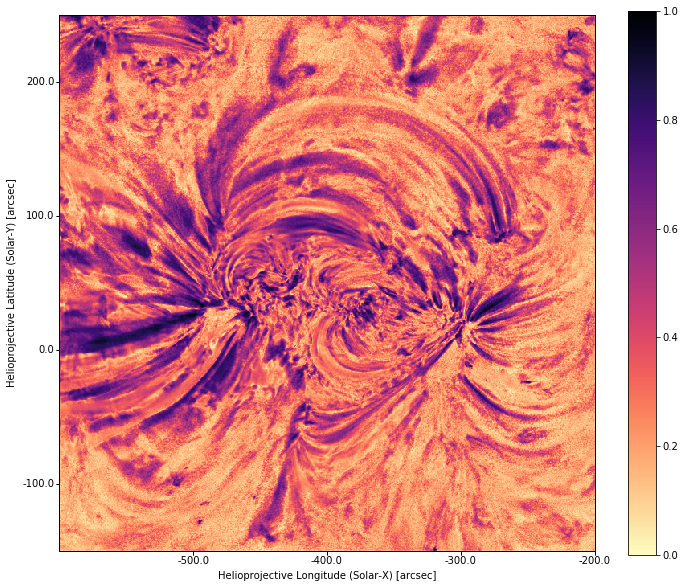

In [39]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=cc_335_171)
im = cc_335_171.plot(axes=ax,vmin=0,vmax=1,cmap='magma_r',title=False)
ax.grid(alpha=0)
fig.colorbar(im)

Computing the timelag for a single channel pair in a single pixel for an equivalent timeseries would take approximately 2 ms in IDL. Assuming this was done in serial, computing the timelag over an entire active region for a single channel pair would take approximately 7.5 minutes. **Using the above method, we've accomplished the same task in about 21 s, a factor of 21 speedup!** Notably, the method presented here is also scalable such that the more computing resources we have available, the shorter our compute time (though this speedup is likely not linear!).

Let's compute the timelag for two channels that are a bit closer together in temperature space.

In [30]:
tl_335_211 = timelags.make_timelag_map(335,211,timelag_bounds=(-3*u.hour,3*u.hour),)

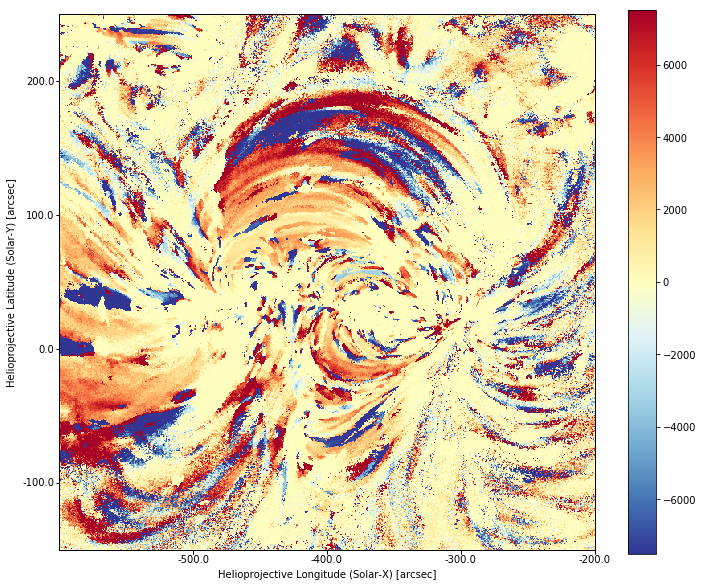

In [31]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_335_211)
im = tl_335_211.plot(axes=ax,vmin=-7.5e3,vmax=7.5e3,cmap='RdYlBu_r',title=False)
ax.grid(alpha=0)
fig.colorbar(im)

Note that we see similar patterns for this channel pair though the timelags are shorter due to the smaller separation of the 335 and 211 channels in temperature space as compared to the 335 and 171 channels. 

Maybe try one more!

In [36]:
tl_94_335 = timelags.make_timelag_map(94,335,timelag_bounds=(-3*u.hour,3*u.hour),)

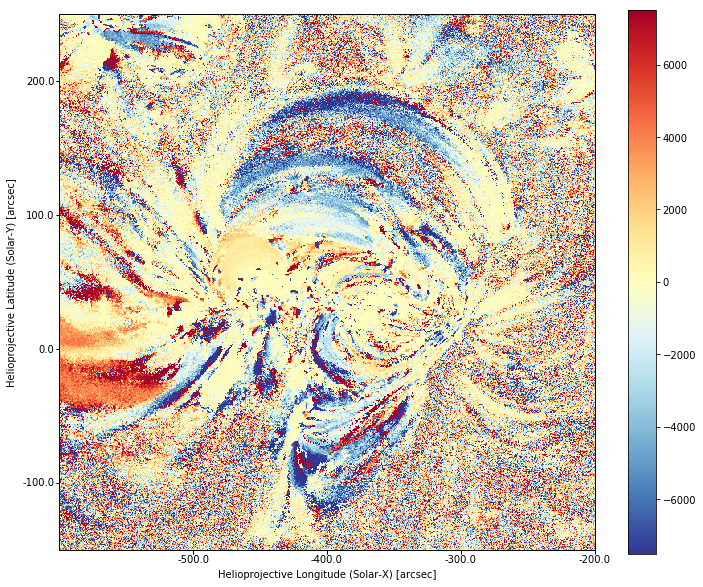

In [37]:
fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection=tl_94_335)
im = tl_94_335.plot(axes=ax,vmin=-7.5e3,vmax=7.5e3,cmap='RdYlBu_r',title=False)
ax.grid(alpha=0)
fig.colorbar(im)

Note that we see many more negative (blue) timelags. This is because the 94 Å channel is double peaked in temperature space (see plot above) such that it has a component hotter and cooler than the 335 Å channel. What this suggests is that the plasma is not cooling through the hot part of the 94 Å passband and helps us place bounds on the temperature evolution of these coronal loop structures.

## Aside: Functions for Computing Level 1.5 Data

Below are some functions for transforming the level 1 data to level 1.5 data and derotating the image.

In [ ]:
ref_map = Map(os.path.join(SAVE_DIR,))

In [ ]:
reference_observer = ref_map.observer_coordinate
reference_date = ref_map.date
reference_center = ref_map.center

In [ ]:
@dask.delayed
def derotate(aia_map):
    new_coord = solar_rotate_coordinate(
        aia_map.center,
        reference_date,
        new_observer_location=reference_observer,
        rot_type='snodgrass')
    xs_pixel = (new_coord.Tx - reference_center.Tx)/aia_map.scale.axis1
    ys_pixel = (new_coord.Ty - reference_center.Ty)/aia_map.scale.axis2
    shifted_data = shift(aia_map.data, [ys_pixel.value, xs_pixel.value])
    derotated_map = Map(shifted_data, aia_map.meta)
    return derotated_map

In [ ]:
@dask.delayed
def save_fits(aia_map):
    fn = os.path.join(SAVE_DIR, 'lev1.5', '{detector}_lev1.5_{date}_{channel}.fits'.format(
            detector=aia_map.meta['detector'].lower(), 
            date=aia_map.date.strftime('%Y%m%dT%H%M%S'),
            channel=aia_map.meta['wavelnth']))
    aia_map.save(fn)
    return fn

In [ ]:
def build_level15_graph(cube):
    m_prep = [dask.delayed(aiaprep)(m) for m in cube.maps]
    m_derot = [derotate(m) for m in m_prep]
    return [save_fits(m) for m in m_derot]